# EOLES_elecRES in Julia

This notebook is a translation to Julia (with [JuMP](https://jump.dev/))
of the 100% renewable electricity optimization model [EOLES_elecRES](https://github.com/BehrangShirizadeh/EOLES_elecRES) which is written in [GAMS](https://www.gams.com/latest/docs/UG_MAIN.html).

More precisely this is the port of the [EOLES_elecRES.gms](https://github.com/BehrangShirizadeh/EOLES_elecRES/blob/master/model/EOLES_elecRES.gms) model. The translation is a close as possible to the original GAMS code, with many reproduction of GAMS code extracts.

**License:**

The original model is licensed under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License ([CC BY-NC-SA 4.0](http://creativecommons.org/licenses/by-nc-sa/4.0/)).
Written by Behrang Shirizadeh, Quentin Perrier and Philippe Quirion, October 2020.

This Julia notebook, which is a derivative work, is made available under the same license by Pierre Haessig, February 2021.

In [1]:
using CSV, DataFrames, PyPlot
using JuMP, GLPK

In [2]:
const DAArray = JuMP.Containers.DenseAxisArray;

## Model data

### Sets

#### hours and months

See GAMS User guide, [§Set Definition/Sequences as Set Elements](https://www.gams.com/latest/docs/UG_SetDefinition.html#UG_SetDefinition_SequencesAsSetElements) for the definition of `*`

sets `h /0*8759/`

         first(h)        'first hour'
         last(h)         'last hour'
         
         first(h) = ord(h)=1;
last(h) = ord(h)=card(h);

alias(h,hh);

In [3]:
h = 0:8759

0:8759

In [4]:
first_h = h .== h[1] # BitArray, with first element true
last_h = h .== h[end]; # BitArray, with last element true

In [5]:
m = [:jan, :feb, :mar, :apr, :may, :jun, :jul, :aug, :sep, :oct, :nov, :dec]

12-element Array{Symbol,1}:
 :jan
 :feb
 :mar
 :apr
 :may
 :jun
 :jul
 :aug
 :sep
 :oct
 :nov
 :dec

#### technology sets

All technologies

In [6]:
tec = [:offshore, :onshore, :pv, :river, :lake, :biogas, :gas, :phs, :battery, :methanation] 

10-element Array{Symbol,1}:
 :offshore
 :onshore
 :pv
 :river
 :lake
 :biogas
 :gas
 :phs
 :battery
 :methanation

Subsets of `tec`

In [7]:
# power plants
gen = [:offshore, :onshore, :pv, :river, :lake, :biogas, :gas]
# variable tecs
vre = [:offshore, :onshore, :pv]
# non-combustible generation
ncomb = [:offshore, :onshore, :pv, :river, :lake, :phs, :battery]
# combustible generation techs
# Remark: in equations, its defined that 'gas' generation is the sum of the generations from 'comb' elements
comb = [:biogas, :methanation] # Q: is it a bug. Should it be biogas and gas?
# storage technologies
str = [:phs, :battery, :methanation]
# technologies for upward FRR
frr = [:lake, :phs, :battery, :gas];

Check that subsets are indeed subsets (i.e. performing the automatic [domain checking](https://www.gams.com/latest/docs/UG_SetDefinition.html#UG_SetDefinition_DomainChecking) of GAMS)

In [8]:
for tec_subset in [gen, vre, ncomb, comb, str, frr]
    @assert issubset(tec_subset, tec) "should be a subset of tec!"
end

### Parameters

Original GAMS definition for months:
```
parameter month(h)  /0*743 1, 744*1439 2, 1440*2183 3, 2184*2903 4
                    2904*3647 5, 3648*4367 6, 4368*5111 7, 5112*5855 8
                    5856*6575 9, 6576*7319 10, 7320*8039 11, 8040*8759 12/
```

observe that February has 29 days, which is compensated by December having only 30:

In [9]:
(1439 - 744 +1)/24, (8759 - 8040 +1)/24

(29.0, 30.0)

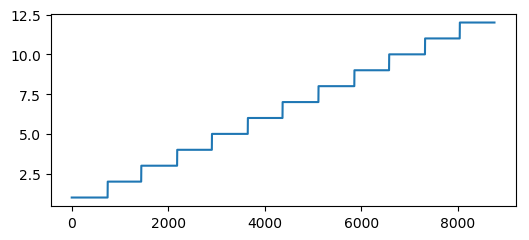

In [10]:
month = [
     repeat([1], 31*24);  repeat([2], 29*24);  repeat([3], 31*24);  repeat([4], 30*24);
     repeat([5], 31*24);  repeat([6], 30*24);  repeat([7], 31*24);  repeat([8], 31*24);
     repeat([9], 30*24); repeat([10], 31*24); repeat([11], 30*24); repeat([12], 30*24)
]

figure(figsize=(6,2.5))
plot(h, month);

Convert `month` values from Integers to corresponding Symbols

In [11]:
month_sym = [m[mk] for mk in month];

Helper to read CSV files

In [12]:
"""
    readdelim(source, dims...; default_value=0.)

Read the CSV file `source` formatted as for the GAMS' `\$onDelim`/`\$offDelim` instructions
(i.e. a long, database-like format).
The vectors of each dimension of the output are specified with `dims`.

Remark: Strings are lowercased and converted to Symbols
"""
function readdelim(source, dims...; default_value=0.)
    print("reading $source...")
    # create reverse maps from value  to index for each dim vector
    ndim = length(dims)
    dim_maps = []
    for dim in dims
        dim_map = Dict((v,i) for (i,v) in enumerate(dim))
        push!(dim_maps, dim_map)
    end
    
    # load datafile
    df = DataFrame(CSV.File(source, header=false))
    ncol = size(df,2)
    @assert ncol == (ndim+1) "$(ndim+1) columns exected in $source, got $(ncol)"
    
    # Create array and fill with data
    a = zeros((length(dim) for dim in dims)...)
    fill!(a, default_value)
    
    to_symb(a) = if (typeof(a) == String) Symbol(lowercase(a)) else a end
    
    for row in eachrow(df)
        if ndim == 1
            i = dim_maps[1][to_symb(row[1])]
            a[i] = row[2]
        elseif ndim == 2
            i = dim_maps[1][to_symb(row[1])]
            j = dim_maps[2][to_symb(row[2])]
            a[i,j] = row[3]
        else
            throw(ArgumentError("only 2 dims supported, got $(ndim)!"))
        end
    end
    # Convert to JuMP.Containers.DenseAxisArray for easier indexing
    return JuMP.Containers.DenseAxisArray(a, dims...)
end

readdelim

parameter `load_factor(vre,h)` 'Production profiles of VRE'

from file `inputs/vre_profiles2006.csv`

In [13]:
load_factor = readdelim("inputs/vre_profiles2006.csv", vre, h; default_value=0.)

reading inputs/vre_profiles2006.csv...

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [:offshore, :onshore, :pv]
    Dimension 2, 0:8759
And data, a 3×8760 Array{Float64,2}:
 0.865143  0.88     0.88      0.873429  …  0.990286  0.991     0.988143
 0.511702  0.52791  0.537973  0.541571     0.826158  0.825222  0.818481
 0.0       0.0      0.0       0.0          0.0       0.0       0.0

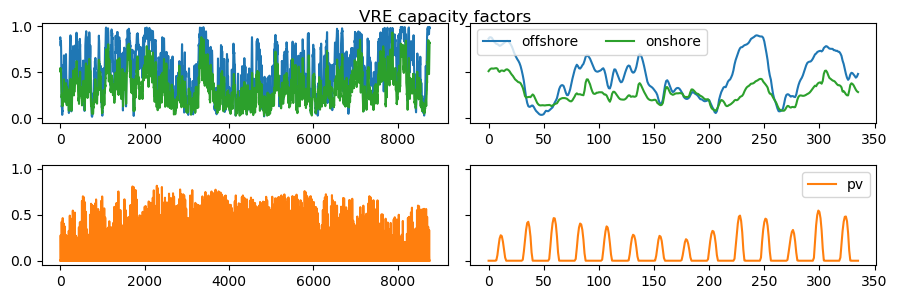

In [14]:
z = 1:24*14 # zoom
fig, ax = subplots(2,2, figsize=(9, 3), sharey=true)

# Wind
ax[1,1].plot(h, load_factor[:offshore,:].data, label=vre[1])
ax[1,1].plot(h, load_factor[:onshore,:].data, "C2", label=vre[2])
ax[1,2].plot(h[z], load_factor[:offshore,:].data[z], label=vre[1])
ax[1,2].plot(h[z], load_factor[:onshore,:].data[z], "C2", label=vre[2])
ax[1,2].legend(ncol=2)

# PV
ax[2,1].plot(h, load_factor[:pv,:].data, "C1", label=vre[3])
ax[2,2].plot(h[z], load_factor[:pv,:].data[z], "C1", label=vre[3])
ax[2,2].legend()

fig.suptitle("VRE capacity factors")
fig.tight_layout();

Parameter `demand(h)` 'demand profile in each hour in GW'

from file `inputs/demand2050_ademe.csv`

In [15]:
demand = readdelim("inputs/demand2050_ademe.csv", h);

reading inputs/demand2050_ademe.csv...

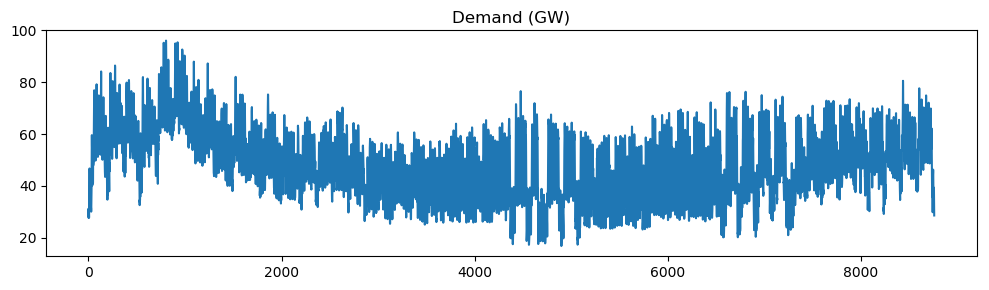

In [16]:
figure(figsize=(10, 3))
plot(h, demand.data)
title("Demand (GW)")
tight_layout()

Parameter `lake_inflows(m)` 'monthly lake inflows in GWh'

from `inputs/lake_inflows.csv`

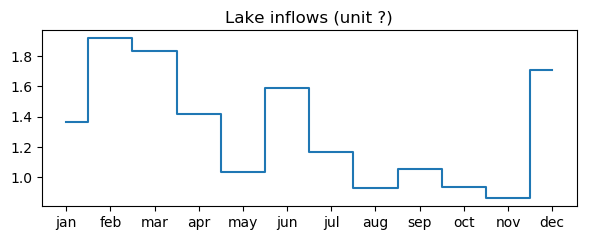

reading inputs/lake_inflows.csv...

In [17]:
lake_inflows = readdelim("inputs/lake_inflows.csv", m)

figure(figsize=(6,2.5))
step(m, lake_inflows.data, where="mid")
title("Lake inflows (unit ?)")
tight_layout()

parameter `gene_river(h)` 'hourly run of river power generation in GWh'

from `inputs/run_of_river.csv`

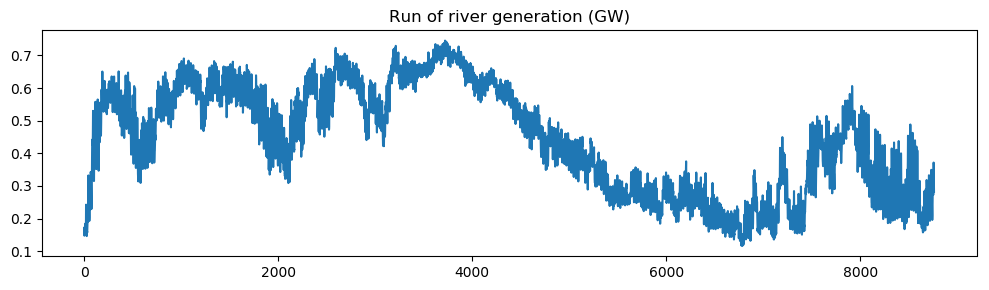

reading inputs/run_of_river.csv...

In [18]:
gene_river = readdelim("inputs/run_of_river.csv", h)

figure(figsize=(10, 3))
plot(h, gene_river.data)
title("Run of river generation (GW)")
tight_layout()

parameter `epsilon(vre)` 'additional FRR requirement for variable renewable energies because of forecast errors'

from `inputs/reserve_requirements.csv`

In [19]:
epsilon = readdelim("inputs/reserve_requirements.csv", vre)
[vre epsilon]

reading inputs/reserve_requirements.csv...

3×2 Array{Any,2}:
 :offshore  0.027
 :onshore   0.027
 :pv        0.038

parameter `capa_ex(tec)` 'existing capacities of the technologies by December 2017 in GW'

from `inputs/existing_capas.csv`

Remark: gas is missing from file, but default value is 0. in `readdelim`

In [20]:
capa_ex = readdelim("inputs/existing_capas.csv", tec)
[tec capa_ex]

reading inputs/existing_capas.csv...

10×2 Array{Any,2}:
 :offshore      0.0
 :onshore       0.0
 :pv            0.0
 :river         7.5
 :lake         12.855
 :biogas        0.0
 :gas           0.0
 :phs           4.94
 :battery       0.0
 :methanation   0.0

parameter `capa_max(tec)` 'maximum capacities of the technologies in GW'

from `inputs/max_capas.csv`

Remarks:
- again "gas" is missing from the file
- but eventually, only the values for offshore, onshore and pv is used to contraint the `CAPA` variable.
- "phs" max capa is set in `pump_capa=9.3` (coherent with file)
- "lake" max capacity is set to 13 (coherent with file)
- "river" capacity is *fixed* to `capa_ex('river')` (7.5, which is coherent with file)

In [21]:
capa_max = readdelim("inputs/max_capas.csv", tec)
[tec capa_max]

reading inputs/max_capas.csv...

10×2 Array{Any,2}:
 :offshore      20.0
 :onshore      120.0
 :pv           218.0
 :river          7.5
 :lake          13.0
 :biogas       100.0
 :gas            0.0
 :phs            9.3
 :battery      100.0
 :methanation  100.0

parameter `capex(tec)` 'annualized power capex cost in M€/GW/year'

from `inputs/annuities.csv`

In [22]:
capex = readdelim("inputs/annuities.csv", tec);

reading inputs/annuities.csv...

parameter `capex_en(str)` 'annualized energy capex cost of storage technologies in M€/GWh/year'

from `inputs/str_annuities.csv`

In [23]:
capex_en = readdelim("inputs/str_annuities.csv", str)
[str capex_en]

reading inputs/str_annuities.csv...

3×2 Array{Any,2}:
 :phs           0.246938
 :battery      10.634
 :methanation   0.0

parameter `fOM(tec)` 'annualized fixed operation and maintenance costs M€/GW/year'

from `inputs/fO&M.csv`

In [24]:
fOM = readdelim("inputs/fO&M.csv", tec);

reading inputs/fO&M.csv...

Total fixed costs:

In [25]:
fixed_costs = DAArray(capex.data + fOM.data, tec) # 'yearly fixed cost of each tec in M€/GW/year'
[tec capex fOM fixed_costs]

10×4 Array{Any,2}:
 :offshore     144.368   47.0318   191.4
 :onshore       77.6621  34.5477   112.21
 :pv            30.0052   9.22619   39.2314
 :river        143.909   14.85     158.759
 :lake         110.233   11.375    121.608
 :biogas         0.0      0.0        0.0
 :gas           33.7653  16.5       50.2653
 :phs           24.6938   7.5       32.1938
 :battery       14.8876   1.96      16.8476
 :methanation    0.0      0.0        0.0

parameter `vOM(tec)` 'Variable operation and maintenance costs in M€/GWh'

from `inputs/vO&M.csv`

In [26]:
vOM = readdelim("inputs/vO&M.csv", tec)
[tec vOM]

reading inputs/vO&M.csv...

10×2 Array{Any,2}:
 :offshore     0.0
 :onshore      0.0
 :pv           0.0
 :river        0.0
 :lake         0.0
 :biogas       0.082
 :gas          0.0
 :phs          0.0
 :battery      0.0021
 :methanation  0.005444

parameter `s_capex(str)` 'charging related annuity of storage in M€/GW/year' /PHS 0, battery 0, methanation 84.16086/;

*Remark: this corresponds with the fact that capex[:methanation] is 0*

In [27]:
s_capex = DAArray([0., 0., 84.16086], str)
[str s_capex]

3×2 Array{Any,2}:
 :phs           0.0
 :battery       0.0
 :methanation  84.1609

parameter `s_opex(str)`    'charging related fOM of storage in M€/GW/year'   /PHS 0, battery 0, methanation 59.25/;

In [28]:
s_opex = DAArray([0., 0., 59.25], str)
[str s_opex]

3×2 Array{Any,2}:
 :phs           0.0
 :battery       0.0
 :methanation  59.25

Charging/discharging efficiency

- parameter `eta_in(str)` 'charging efficiency of storage technologies' /PHS 0.95, battery 0.9, methanation 0.59/;
- parameter `eta_out(str)` 'discharging efficiency of storage technolgoies' /PHS 0.9, battery 0.95, methanation 0.45/;

In [29]:
eta_in  = DAArray([0.95, 0.90, 0.59], str)
eta_out = DAArray([0.90, 0.95, 0.45], str)
[str eta_in eta_out]

3×3 Array{Any,2}:
 :phs          0.95  0.9
 :battery      0.9   0.95
 :methanation  0.59  0.45

Scalar parameters

In [30]:
pump_capa = 9.3 # pumping capacity in GW
max_phs = 0.18 # maximum volume of energy can be stored in PHS reservoir in TWh
max_biogas = 15 # maxium energy that can be generated by biogas in TWh
load_uncertainty = 0.01 # uncertainty coefficient for hourly demand
delta = 0.1; # load variation factor

## Model

In [61]:
using Clp

┌ Info: Precompiling Clp [e2554f3b-3117-50c0-817c-e040a3ddf72d]
└ @ Base loading.jl:1260


In [62]:
RES_FR = Model(Clp.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Clp

### Variables

See [§Variable Attributes](https://www.gams.com/latest/docs/UG_Variables.html#UG_Variables_VariableAttributes) for `.up`, `.lo`, `.fx` and `.l`

See [§Styles for Variable Declaration](https://www.gams.com/latest/docs/UG_Variables.html#UG_Variables_StylesForVariableDeclaration) for the fact it's possible to redeclare the type of a variable. E.g. here to state it's positive

```
variables        GENE(tec,h)     'hourly energy generation in TWh'
                 CAPA(tec)       'overal yearly installed capacity in GW'
                 STORAGE(str,h)  'hourly electricity input of battery storage GW'
                 S(str)          'charging power capacity of each storage technology'
                 STORED(str,h)   'energy stored in each storage technology in GWh'
                 CAPACITY(str)   'energy volume of storage technologies in GWh'
                 RSV(frr,h)      'required upward frequency restoration reserve in GW'
                 COST            'final investment cost in b€'

positive variables GENE(tec,h),CAPA(tec),STORAGE(str,h), S(str),STORED(str,h),CAPACITY(str),RSV(frr,h);
```

In [63]:
@variable(RES_FR, GENE[tec,h] >= 0)    # hourly energy generation in TWh
@variable(RES_FR, CAPA[tec] >= 0)      # overal yearly installed capacity in GW
@variable(RES_FR, STORAGE[str,h] >= 0) # hourly electricity input of battery storage GW
@variable(RES_FR, S[str] >= 0)         # charging power capacity of each storage technology. Remark S(str) is constrainted <= CAPA(str);
@variable(RES_FR, STORED[str,h] >= 0)  # energy stored in each storage technology in GWh
@variable(RES_FR, CAPACITY[str] >= 0)  # energy volume of storage technologies in GWh
@variable(RES_FR, RSV[frr,h] >= 0)     # required upward frequency restoration reserve in GW

2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, [:lake, :phs, :battery, :gas]
    Dimension 2, 0:8759
And data, a 4×8760 Array{VariableRef,2}:
 RSV[lake,0]     RSV[lake,1]     RSV[lake,2]     …  RSV[lake,8759]
 RSV[phs,0]      RSV[phs,1]      RSV[phs,2]         RSV[phs,8759]
 RSV[battery,0]  RSV[battery,1]  RSV[battery,2]     RSV[battery,8759]
 RSV[gas,0]      RSV[gas,1]      RSV[gas,2]         RSV[gas,8759]

In [64]:
@variable(RES_FR, COST);

Initial and fixed values

```
CAPA.up('phs') = pump_capa;
CAPA.fx('river')= capa_ex('river');
CAPA.up('lake') = 13;
CAPA.lo('lake') = capa_ex('lake');
GENE.up('river',h) = gene_river(h)*capa_ex('river');
S.up('phs') = pump_capa;
CAPACITY.up('phs') = max_phs*1000;
CAPA.up('offshore') = capa_max('offshore');
CAPA.up('onshore') = capa_max('onshore');
CAPA.up('pv') = capa_max('pv');
```

In [65]:
@constraint(RES_FR, CAPA[:phs] <= pump_capa)
@constraint(RES_FR, CAPA[:river] == capa_ex[:river])
@constraint(RES_FR, CAPA[:lake] <= 13)
@constraint(RES_FR, CAPA[:lake] >= capa_ex[:lake])

CAPA[lake] ≥ 12.855

Warning: GENE[:river] upper bound means rivers can be silently curtailed! Perhaps it should be _fixed_ instead.

In [66]:
@constraint(RES_FR, GENE_river_up[hk = h], 
            GENE[:river,hk] .>= gene_river[hk]*capa_ex[:river]);

In [67]:
@constraint(RES_FR, S[:phs] <= pump_capa)
@constraint(RES_FR, CAPACITY[:phs] <= max_phs*1000)
@constraint(RES_FR, CAPA[:offshore] <= capa_max[:offshore])
@constraint(RES_FR, CAPA[:onshore] <= capa_max[:onshore])
@constraint(RES_FR, CAPA[:pv] <= capa_max[:pv]);

### Equations

`gene_vre(vre,h)` variables renewable profiles generation:

In [68]:
@constraint(RES_FR, gene_vre[vrek=vre, hk=h],
            GENE[vrek,hk] == CAPA[vrek]*load_factor[vrek,hk]);

Equation `gene_capa(tec,h)` capacity and generation relation for technologies:

In [69]:
@constraint(RES_FR, gene_capa[teck=tec, hk=h],
            CAPA[teck] >= GENE[teck,hk]);

`combustion(h)` the relationship of combustible technologies (i.e. 'gas' = 'biogas' + 'methanation'):

In [70]:
@constraint(RES_FR, combustion[hk=h],
            GENE[:gas,hk] == sum(GENE[combk,hk] for combk in comb));

`capa_frr(frr,h)` capacity needed for the secondary reserve requirements:

    CAPA(frr)               =g=     GENE(frr,h) + RSV(frr,h);

In [71]:
@constraint(RES_FR, capa_frr[frrk=frr, hk=h],
            CAPA[frrk] >= GENE[frrk,hk] + RSV[frrk,hk]);

`storing(h,h+1,str)` the definition of stored energy in the storage options;

    STORED(str,h+1) =e= STORED(str,h) + STORAGE(str,h)*eta_in(str) - GENE(str,h)/eta_out(str);

Remark: see GAMS UG [§Lag and Lead Operators](https://www.gams.com/latest/docs/UG_OrderedSets.html#UG_OrderedSets_LagLeadOperators) for the meaning of `h+1`.
However, it's not clear to me why the equation is declared on both `h` and `h+1`. 

In [72]:
@constraint(RES_FR, storing[strk=str, hk=h[1:end-1]],
            STORED[strk,hk+1] == STORED[strk,hk] + 
            STORAGE[strk,hk]*eta_in[strk] - GENE[strk,hk]/eta_out[strk]);

In [73]:
storing[:battery,2]

storing[battery,2] : 1.0526315789473684 GENE[battery,2] - 0.9 STORAGE[battery,2] - STORED[battery,2] + STORED[battery,3] = 0.0

`storage_const(str,first,last)` storage in the first hour is equal to the storage in the last hour:

    STORED(str,first) =e= STORED(str,last)+STORAGE(str,last)*eta_in(str)-GENE(str,last)/eta_out(str);

In [74]:
@constraint(RES_FR, storage_const[strk=str],
            STORED[strk,h[1]] == STORED[strk,h[end]] + 
            STORAGE[strk,h[end]]*eta_in[strk] - GENE[strk,h[end]]/eta_out[strk]);

In [75]:
storage_const[:battery]

storage_const[battery] : 1.0526315789473684 GENE[battery,8759] - 0.9 STORAGE[battery,8759] + STORED[battery,0] - STORED[battery,8759] = 0.0

`lake_res(m)` constraint on water for lake reservoirs:

    lake_inflows(m) =g= sum(h$(month(h) = ord(m)),GENE('lake',h))/1000;

In [76]:
@constraint(RES_FR, lake_res[mk=m],
            lake_inflows[mk] >= sum(GENE[:lake,:].data[month_sym.==mk])/1000);

In [77]:
#print(lake_res[:jan])

`stored_cap(str,h)` maximum energy that is stored in storage units:

In [78]:
@constraint(RES_FR, stored_cap[strk=str, hk=h],
            STORED[strk,hk] <= CAPACITY[strk]);

`storage_capa1(str,h)` the capacity with hourly charging relationship of storage:

In [79]:
@constraint(RES_FR, storage_capa1[strk=str, hk=h],
            S[strk] >= STORAGE[strk,hk]);

`storage_capa2(str)` storage power limit:

In [80]:
@constraint(RES_FR, storage_capa2[strk=str],
            S[strk] <= CAPA[strk]);

`biogas_const` maximum energy can be produced by biogas:

    sum(h,GENE('biogas',h)) =l=     max_biogas*1000;

In [81]:
@constraint(RES_FR, biogas_const,
            sum(GENE[:biogas,:]) <= max_biogas*1000);

`reserves(h)` FRR requirement:

In [82]:
@constraint(RES_FR, reserves[hk=h],
            sum(RSV[:,hk]) == sum(epsilon[vrek] * CAPA[vrek] for vrek in vre) +
            demand[hk]*load_uncertainty*(1+delta)
);

`adequacy(h)` supply/demand relation:

In [83]:
@constraint(RES_FR, adequacy[hk=h],
            sum(GENE[ncombk,hk] for ncombk in ncomb) + GENE[:gas,hk] >=
            demand[hk] + sum(STORAGE[:,hk]));

In [84]:
adequacy[3]

adequacy[3] : GENE[offshore,3] + GENE[onshore,3] + GENE[pv,3] + GENE[river,3] + GENE[lake,3] + GENE[gas,3] + GENE[phs,3] + GENE[battery,3] - STORAGE[phs,3] - STORAGE[battery,3] - STORAGE[methanation,3] ≥ 27.9874884

`obj` the final objective function which is `COST`

    COST                    =e=     (
        sum(tec,(CAPA(tec)-capa_ex(tec))*capex(tec))+ 
        sum(str,CAPACITY(str)*capex_en(str))+
        sum(tec,(CAPA(tec)*fOM(tec)))+ 
        sum(str,S(str)*(s_capex(str)+s_opex(str))) + 
        sum((tec,h),GENE(tec,h)*vOM(tec))
        )/1000;

In [85]:
@constraint(RES_FR, cost,
            COST == (
            sum( (CAPA[teck]-capa_ex[teck])*capex[teck] for teck in tec) +
            sum( CAPACITY[strk]*capex_en[strk] for strk in str) +
            sum( CAPA[teck]*fOM[teck] for teck in tec) +
            sum( S[strk]*(s_capex[strk]+s_opex[strk]) for strk in str) +
            sum( GENE[teck,hk]*vOM[teck] for teck in tec for hk in h)
            )/1000 );

In [86]:
@objective(RES_FR, Min, COST);

Solve (~7 minutes with Clp)

In [87]:
optimize!(RES_FR);

Coin0506I Presolve 157694 (-105132) rows, 131411 (-43806) columns and 556610 (-219025) elements
Clp0006I 0  Obj 0.13561339 Primal inf 2582648.1 (17520) Dual inf 4.1559333e+16 (78842)
Clp0006I 870  Obj 30.388428 Primal inf 729557.89 (11186) Dual inf 2.5300521e+16 (45770)
Clp0006I 1739  Obj 32.59457 Primal inf 625312.23 (10885) Dual inf 2.3603488e+09 (43686)
Clp0006I 2608  Obj 32.843534 Primal inf 586463.26 (10493) Dual inf 2.1899128e+09 (41530)
Clp0006I 3477  Obj 32.949949 Primal inf 528159.36 (10166) Dual inf 2.0375933e+09 (40737)
Clp0006I 4346  Obj 33.102105 Primal inf 483046.08 (9805) Dual inf 1.8641528e+09 (39342)
Clp0006I 5215  Obj 33.302744 Primal inf 421772.2 (9443) Dual inf 1.6868025e+09 (37515)
Clp0006I 6084  Obj 33.511212 Primal inf 311745.65 (9095) Dual inf 1.5343216e+09 (35587)
Clp0006I 6953  Obj 33.663564 Primal inf 234642.74 (8668) Dual inf 1.3509483e+09 (34126)
Clp0006I 7822  Obj 33.670717 Primal inf 205122.6 (8434) Dual inf 1.1922803e+09 (32029)
Clp0006I 8691  Obj 36.660

In [88]:
termination_status(RES_FR)

OPTIMAL::TerminationStatusCode = 1

In [89]:
value(COST)

19.76198071262182

remark: the total cost should be 21.83

Installed capacities:

In [95]:
CAPA_res = value.(CAPA)
[tec CAPA_res] # GW

10×2 Array{Any,2}:
 :offshore       8.4531
 :onshore       76.0295
 :pv           111.716
 :river          7.5
 :lake          12.855
 :biogas        31.1178
 :gas           31.1178
 :phs            9.3
 :battery       18.9574
 :methanation   31.1178

In [91]:
spot_price = 1000000*dual.(adequacy);

In [92]:
marginal_cost = sum(spot_price)/8760;

In [93]:
marginal_cost # €/MWh

55.584343889472045

For comparison, this is the `2006.txt` file output (with minor edits) from the GAMS model run:

```
I)Overall investment cost is       21.83b€

II)the Renewable capacity

Offshore                       12.90 GW
onsore                         79.39 GW
PV                            121.77 GW
run of river                    7.50 GW
lake                           12.86 GW
biogas                         33.11 GW
gas                            33.11 GW
Battery                        20.06 GW
PHS                             9.30 GW
methanation                    33.11 GW

III)Needed storage volume and storage charging power

Battery Storage                73.73 GWh
PHS Storage                   180.00 GWh
methane storage             12576.24 GWh
Battery Storage                20.06 GW
PHS Storage                     9.30 GW
methane storage                 7.66 GW

IV)Secondary reserve requirements

lake                            8.09GW
gas                             8.18GW
Pumped Storage                  8.15GW
Battery                         8.16GW

V)Overall yearly energy generation of each technology

Offshore                       59.37 TWh
onsore                        225.83 TWh
PV                            173.16 TWh
run of river                   29.19 TWh
lake                           15.82TWh
biogas                         15.00 TWh
gas                            25.05  TWh
battery                        13.34 TWh
phs                            20.93  TWh
Methanation                    10.05TWh

VI)more details

LCOE for Offshore                      41.58 €/MWh
LCOE for Onshore                       39.45 €/MWh
LCOE for PV                            27.59 €/MWh
LCOE for Run-of-river                  40.80 €/MWh
LCOE for Lake                          98.84 €/MWh
LCOE for Biogas                        82.00 €/MWh
LCOE for Gas                           66.43 €/MWh
LCOS for battery                       84.10 €/MWh
LCOS for pumped storage                16.43 €/MWh
LCOS for methanation                  109.34 €/MWh

Load Curtailment       12.03% and the storage loss         6.49%
LCOE of the system is        42.12 €/MWh or        51.69 €/MWh
Average spot price of the system is        56.48 €/MWh

capacity factors

Offshore                         0.53
onsore                           0.32
PV                               0.16
run of river                     0.44
lake                             0.14
biogas                           0.05
gas                              0.09
```